In [1]:
import networkx as nx
import os
import pandas as pd
import matplotlib.pylab as plt
import math
import numpy as np
from tqdm import tqdm
from scipy.sparse.linalg import svds, eigs

In [2]:
# read the data
df = pd.read_csv("./new_train_data.csv")
dfpre = pd.read_csv("./new_test_data.csv")

In [3]:
edges = (df.loc[df[['label']].values == 1])[['node1', 'node2']].values
neg_edges = (df.loc[df[['label']].values == 0])[['node1', 'node2']].values

### 建圖

In [4]:
link_graph = nx.DiGraph()

for edge in edges:
    link_graph.add_edge(edge[0], edge[1])

for edge in neg_edges:
    if not link_graph.has_edge(edge[0], edge[1]):
        link_graph.add_edge(edge[0], edge[1])

for index, row in dfpre.iterrows():
    if not link_graph.has_edge(row['node1'], row['node2']):
        link_graph.add_edge(row['node1'], row['node2'])

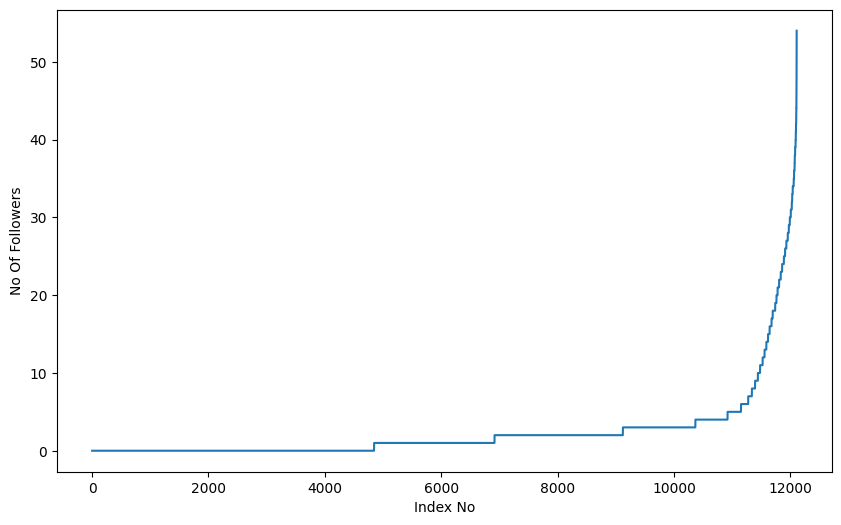

In [5]:
indegree_dist = list(dict(link_graph.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

In [6]:
print('Number of nodes', len(link_graph.nodes))
print('Number of edges', len(link_graph.edges))
print('Average degree', sum(dict(link_graph.degree).values()) / len(link_graph.nodes))

Number of nodes 12110
Number of edges 29923
Average degree 4.94186622625929


### split train and test

In [7]:
X = df[['node1', 'node2']].values
Y = df[['label']].values


# 預測資料
Xpre = dfpre[['node1', 'node2']].values


In [8]:
print(Xpre)

[[40963 40966]
 [ 4544 49357]
 [38726 38760]
 ...
 [22854 26234]
 [38127 38215]
 [ 1064 23907]]


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.05, random_state=42)

In [10]:
print(X_train)

[[ 1417  8586]
 [ 7728  4501]
 [34324 47840]
 ...
 [38711 38871]
 [23058 26893]
 [38543  8632]]


In [11]:
print(X_train.shape)
print(Xpre.shape)

(22800, 2)
(6000, 2)


### Jaccard Distance:

In [12]:
#for followees
def jaccard_for_followees(a,b):
    try:
        if len(set(link_graph.successors(a))) == 0  | len(set(link_graph.successors(b))) == 0:
            return 0
        sim = (len(set(link_graph.successors(a)).intersection(set(link_graph.successors(b)))))/\
                                    (len(set(link_graph.successors(a)).union(set(link_graph.successors(b)))))
    except:
        return 0
    return sim

In [13]:
#for followers
def jaccard_for_followers(a,b):
    try:
        if len(set(link_graph.predecessors(a))) == 0  | len(set(link_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(link_graph.predecessors(a)).intersection(set(link_graph.predecessors(b)))))/\
                                 (len(set(link_graph.predecessors(a)).union(set(link_graph.predecessors(b)))))
        return sim
    except:
        return 0.   

### Cosine distance

In [14]:
#for followees
def cosine_for_followees(a,b):
    try:
        if len(set(link_graph.successors(a))) == 0  | len(set(link_graph.successors(b))) == 0:
            return 0
        sim = (len(set(link_graph.successors(a)).intersection(set(link_graph.successors(b)))))/\
                                    (math.sqrt(len(set(link_graph.successors(a)))*len((set(link_graph.successors(b))))))
        return sim
    except:
        return 0

In [15]:
def cosine_for_followers(a,b):
    try:
        
        if len(set(link_graph.predecessors(a))) == 0  | len(set(link_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(link_graph.predecessors(a)).intersection(set(link_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(link_graph.predecessors(a))))*(len(set(link_graph.predecessors(b)))))
        return sim
    except:
        return 0

### Page Ranking

In [16]:
pr = nx.pagerank(link_graph, alpha=0.85)
print('min',pr[min(pr, key=pr.get)])
print('max',pr[max(pr, key=pr.get)])
print('mean',float(sum(pr.values())) / len(pr))
#for imputing to nodes which are not there in Train data
mean_pr = float(sum(pr.values())) / len(pr)
print(mean_pr)

min 4.836695288890479e-05
max 0.0014433074506641456
mean 8.257638315441399e-05
8.257638315441399e-05


### Shortest path

In [17]:
#if has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if link_graph.has_edge(a,b):
            link_graph.remove_edge(a,b)
            p= nx.shortest_path_length(link_graph,source=a,target=b)
            link_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(link_graph,source=a,target=b)
        return p
    except:
        return -1

### Checking for same community

In [18]:
#getting weekly connected edges from graph 
# weakly_connected_components 回傳的是一個list，list中的每個元素都是一個set，set中包含了一個弱連通圖中的所有節點
wcc=list(nx.weakly_connected_components(link_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if link_graph.has_edge(b,a):
        return 1
    if link_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                link_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    link_graph.add_edge(a,b)
                    return 0
                else:
                    link_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

### Adamic/Adar Index

In [19]:
#adar index
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(link_graph.successors(a)).intersection(set(link_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(link_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

### following back

In [20]:
def follows_back(a,b):
    if link_graph.has_edge(b,a):
        return 1
    else:
        return 0

### Katz Centrality

In [21]:
katz = nx.katz.katz_centrality(link_graph,alpha=0.005,beta=1)
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))
mean_katz = float(sum(katz.values())) / len(katz)
print(mean_katz)

min 0.008969781853457828
max 0.01150807155466768
mean 0.009083849448209995
0.009083849448209995


### Hits Score

In [22]:
hits = nx.hits(link_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean',float(sum(hits[0].values())) / len(hits[0]))

min -1.717300930910228e-20
max 0.0031432953797037033
mean 8.257638315441768e-05


In [23]:
# 建立一個新的dataframe
df_final_train = pd.DataFrame()
df_final_train['source_node'] = X_train[:,0]
df_final_train['destination_node'] = X_train[:,1]
df_final_train['indicator_link'] = Y_train[:]
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

Our train matrix size  (22800, 3)


,source_node,destination_node,indicator_link
0,1417,8586,0
1,7728,4501,0


In [24]:
df_final_test = pd.DataFrame()
df_final_test['source_node'] = X_test[:,0]
df_final_test['destination_node'] = X_test[:,1]
df_final_test['indicator_link'] = Y_test[:]
print("Our test matrix size ",df_final_test.shape)
df_final_test.head(2)

Our test matrix size  (1200, 3)


,source_node,destination_node,indicator_link
0,10325,11788,1
1,17275,46736,1


In [25]:
# predict
df_final_predict = pd.DataFrame()
df_final_predict['source_node'] = Xpre[:,0]
df_final_predict['destination_node'] = Xpre[:,1]
print("Our predict matrix size ",df_final_predict.shape)
df_final_predict.head(2)

Our predict matrix size  (6000, 2)


,source_node,destination_node
0,40963,40966
1,4544,49357


In [26]:
# #mapping jaccrd followers to train and test data
# df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:
#                                         jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
# df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:
#                                         jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

# #mapping jaccrd followees to train and test data
# df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:
#                                         jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
# df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:
#                                         jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)


    #mapping jaccrd followers to train and test data
df_final_train['cosine_followers'] = df_final_train.apply(lambda row:
                                        cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
df_final_test['cosine_followers'] = df_final_test.apply(lambda row:
                                        cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

#mapping jaccrd followees to train and test data
df_final_train['cosine_followees'] = df_final_train.apply(lambda row:
                                        cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
df_final_test['cosine_followees'] = df_final_test.apply(lambda row:
                                        cosine_for_followees(row['source_node'],row['destination_node']),axis=1)


In [27]:
# #mapping jaccrd followers to train and test data
# df_final_predict['jaccard_followers'] = df_final_predict.apply(lambda row:
#                                         jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

# #mapping jaccrd followees to train and test data
# df_final_predict['jaccard_followees'] = df_final_predict.apply(lambda row:
#                                         jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)


    #mapping jaccrd followers to train and test data
df_final_predict['cosine_followers'] = df_final_predict.apply(lambda row:
                                        cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

#mapping jaccrd followees to train and test data
df_final_predict['cosine_followees'] = df_final_predict.apply(lambda row:
                                        cosine_for_followees(row['source_node'],row['destination_node']),axis=1)

In [28]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(link_graph.predecessors(row['source_node']))
            s2=set(link_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(link_graph.predecessors(row['destination_node']))
            d2=set(link_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [29]:
df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)

df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)


In [30]:
df_final_predict['num_followers_s'], df_final_predict['num_followers_d'], \
df_final_predict['num_followees_s'], df_final_predict['num_followees_d'], \
df_final_predict['inter_followers'], df_final_predict['inter_followees']= compute_features_stage1(df_final_predict)

In [31]:
# #mapping adar index on train
# df_final_train['adar_index'] = df_final_train.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
# #mapping adar index on test
# df_final_test['adar_index'] = df_final_test.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)

# --------------------------------------------------------------------------------------------------------
df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

#mapping followback or not on test
df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

# --------------------------------------------------------------------------------------------------------
# mapping same component of wcc or not on train
df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

# mapping same component of wcc or not on train
df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

# --------------------------------------------------------------------------------------------------------
#mapping shortest path on train 
df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
#mapping shortest path on test
df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

In [32]:
# #mapping adar index on train
# df_final_predict['adar_index'] = df_final_predict.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)

# --------------------------------------------------------------------------------------------------------
#mapping followback or not on train
df_final_predict['follows_back'] = df_final_predict.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

#--------------------------------------------------------------------------------------------------------
# mapping same component of wcc or not on train
df_final_predict['same_comp'] = df_final_predict.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

# --------------------------------------------------------------------------------------------------------
# mapping shortest path on train 
df_final_predict['shortest_path'] = df_final_predict.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

In [33]:
#weight for source and destination of each link
Weight_in = {}
Weight_out = {}
for i in  tqdm(link_graph.nodes()):
    s1=set(link_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(link_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|██████████| 12110/12110 [00:00<00:00, 362377.62it/s]


In [34]:
#mapping to pandas train
df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

#mapping to pandas test
df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))


#some features engineerings on the in and out weights
df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

#some features engineerings on the in and out weights
df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)

In [35]:
#mapping to pandas train
df_final_predict['weight_in'] = df_final_predict.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
df_final_predict['weight_out'] = df_final_predict.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))


#some features engineerings on the in and out weights
df_final_predict['weight_f1'] = df_final_predict.weight_in + df_final_predict.weight_out
df_final_predict['weight_f2'] = df_final_predict.weight_in * df_final_predict.weight_out
df_final_predict['weight_f3'] = (2*df_final_predict.weight_in + 1*df_final_predict.weight_out)
df_final_predict['weight_f4'] = (1*df_final_predict.weight_in + 2*df_final_predict.weight_out)

In [36]:
#page rank for source and destination in Train and Test
#if anything not there in train graph then adding mean page rank 
df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))
#================================================================================

#Katz centrality score for source and destination in Train and test
#if anything not there in train graph then adding mean katz score
df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))

df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))
#================================================================================

#Hits algorithm score for source and destination in Train and test
#if anything not there in train graph then adding 0
df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
#================================================================================

#Hits algorithm score for source and destination in Train and Test
#if anything not there in train graph then adding 0
df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))

In [37]:
#page rank for source and destination in Train and Test
#if anything not there in train graph then adding mean page rank 
df_final_predict['page_rank_s'] = df_final_predict.source_node.apply(lambda x:pr.get(x,mean_pr))
df_final_predict['page_rank_d'] = df_final_predict.destination_node.apply(lambda x:pr.get(x,mean_pr))
#================================================================================

#Katz centrality score for source and destination in Train and test
#if anything not there in train graph then adding mean katz score
df_final_predict['katz_s'] = df_final_predict.source_node.apply(lambda x: katz.get(x,mean_katz))
df_final_predict['katz_d'] = df_final_predict.destination_node.apply(lambda x: katz.get(x,mean_katz))
#================================================================================

#Hits algorithm score for source and destination in Train and test
#if anything not there in train graph then adding 0
df_final_predict['hubs_s'] = df_final_predict.source_node.apply(lambda x: hits[0].get(x,0))
df_final_predict['hubs_d'] = df_final_predict.destination_node.apply(lambda x: hits[0].get(x,0))
#================================================================================

#Hits algorithm score for source and destination in Train and Test
#if anything not there in train graph then adding 0
df_final_predict['authorities_s'] = df_final_predict.source_node.apply(lambda x: hits[1].get(x,0))
df_final_predict['authorities_d'] = df_final_predict.destination_node.apply(lambda x: hits[1].get(x,0))

In [38]:
# df_final_train columns的鳴子
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'follows_back', 'same_comp', 'shortest_path',
       'weight_in', 'weight_out', 'weight_f1', 'weight_f2', 'weight_f3',
       'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s', 'katz_d', 'hubs_s',
       'hubs_d', 'authorities_s', 'authorities_d'],
      dtype='object')

In [39]:
df_final_train.head()

,source_node,destination_node,indicator_link,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,...,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d
0,1417,8586,0,0.0,0.0,0,12,2,9,0,...,1.632456,2.316228,0.000048,0.000166,0.008970,0.009535,0.000025,0.000165,5.150456e-20,3.865156e-04
1,7728,4501,0,0.0,0.0,2,4,4,0,0,...,1.861807,1.991564,0.000069,0.000082,0.009059,0.009151,0.000091,-0.000000,6.920039e-06,3.741986e-05
2,34324,47840,1,0.0,0.0,1,1,2,0,0,...,3.000000,3.000000,0.000090,0.000086,0.009015,0.009015,0.000005,-0.000000,-1.030091e-19,2.656042e-07
3,28105,29590,0,0.0,0.0,0,4,2,0,0,...,2.154701,2.577350,0.000048,0.000089,0.008970,0.009155,0.000009,-0.000000,-2.575228e-20,1.530728e-04
4,5319,17288,1,0.0,0.0,0,1,2,0,0,...,3.000000,3.000000,0.000048,0.000069,0.008970,0.009015,0.000072,-0.000000,-1.545137e-19,3.905121e-06


In [40]:
df_final_predict.head()

,source_node,destination_node,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,...,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d
0,40963,40966,0.000000,0.000000,0,3,1,0,0,0,...,3.000000,3.000000,0.000048,0.000121,0.008970,0.009107,0.000001,-0.000000,5.150456e-20,0.000021
1,4544,49357,0.000000,0.000000,5,2,3,0,0,0,...,2.414214,2.707107,0.000109,0.000081,0.009203,0.009062,0.000053,-0.000000,7.654970e-05,0.000096
2,38726,38760,0.025102,0.074536,27,23,12,15,3,1,...,0.733257,0.840970,0.000275,0.000208,0.010222,0.010034,0.000722,0.001192,1.241298e-03,0.001315
3,4636,38678,0.000000,0.000000,0,16,4,11,0,0,...,1.339562,1.730441,0.000048,0.000194,0.008970,0.009705,0.000037,0.000554,2.060182e-19,0.000652
4,26789,5842,0.000000,0.000000,0,3,43,0,0,0,...,2.176777,1.353553,0.000048,0.000065,0.008970,0.009110,0.002234,-0.000000,-1.030091e-19,0.000175


In [41]:
#for svd features to get feature vector creating a dict node val and inedx in svd vector
sadj_col = sorted(link_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [42]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [43]:
Adj = nx.adjacency_matrix(link_graph,nodelist=sorted(link_graph.nodes())).asfptype()

In [44]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (12110, 12110)
U Shape (12110, 6)
V Shape (6, 12110)
s Shape (6,)


In [45]:
#===================================================================================================

df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)

df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
#===================================================================================================

df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
#===================================================================================================

df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)

df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

#===================================================================================================

df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

In [46]:
#===================================================================================================

df_final_predict[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
df_final_predict.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)

df_final_predict[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
df_final_predict.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
#===================================================================================================

df_final_predict[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
df_final_predict.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

df_final_predict[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
df_final_predict.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
#===================================================================================================
#===================================================================================================

In [47]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'follows_back', 'same_comp', 'shortest_path',
       'weight_in', 'weight_out', 'weight_f1', 'weight_f2', 'weight_f3',
       'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s', 'katz_d', 'hubs_s',
       'hubs_d', 'authorities_s', 'authorities_d', 'svd_u_s_1', 'svd_u_s_2',
       'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1',
       'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6',
       'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5',
       'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4',
       'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [48]:
df_final_predict.columns

Index(['source_node', 'destination_node', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'follows_back', 'same_comp', 'shortest_path',
       'weight_in', 'weight_out', 'weight_f1', 'weight_f2', 'weight_f3',
       'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s', 'katz_d', 'hubs_s',
       'hubs_d', 'authorities_s', 'authorities_d', 'svd_u_s_1', 'svd_u_s_2',
       'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1',
       'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6',
       'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5',
       'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4',
       'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [49]:
#for train dataset

train_followers_s = np.array(df_final_train['num_followers_s'])
train_followers_d = np.array(df_final_train['num_followers_d'])
preferential_followers=[]
for i in range(len(train_followers_s)):
    preferential_followers.append(train_followers_d[i]*train_followers_s[i])
df_final_train['preferential_followers']= preferential_followers
df_final_train.head()

,source_node,destination_node,indicator_link,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,...,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_followers
0,1417,8586,0,0.0,0.0,0,12,2,9,0,...,4.998790e-20,5.906559e-20,3.514506e-20,-1.138545e-02,-9.438929e-04,-1.729691e-02,3.845337e-02,-7.385193e-03,-1.320189e-02,0
1,7728,4501,0,0.0,0.0,2,4,4,0,0,...,1.237670e-18,1.702110e-18,1.099817e-18,-2.247119e-03,-5.496633e-04,-2.869522e-03,-4.200889e-04,-5.400184e-04,-4.789851e-04,8
2,34324,47840,1,0.0,0.0,1,1,2,0,0,...,9.812607e-19,1.288874e-18,7.498052e-19,-8.317701e-19,-1.272441e-19,8.980132e-21,7.428843e-19,1.043870e-18,5.025609e-19,1
3,28105,29590,0,0.0,0.0,0,4,2,0,0,...,7.588296e-19,1.139531e-18,6.666326e-19,8.194609e-03,-4.365139e-03,-7.121881e-03,-3.954341e-03,-8.726623e-03,-5.243655e-03,0
4,5319,17288,1,0.0,0.0,0,1,2,0,0,...,1.705581e-19,2.247972e-19,1.159910e-19,-1.223269e-18,-1.930206e-19,3.786221e-20,1.349976e-18,1.681055e-18,8.441270e-19,0


In [50]:
# for test dataset

test_followers_s = np.array(df_final_test['num_followers_s'])
test_followers_d = np.array(df_final_test['num_followers_d'])
preferential_followers=[]
for i in range(len(test_followers_s)):
    preferential_followers.append(test_followers_d[i]*test_followers_s[i])
df_final_test['preferential_followers']= preferential_followers
df_final_test.head()

,source_node,destination_node,indicator_link,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,...,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_followers
0,10325,11788,1,0.0,0.0,0,1,1,0,0,...,2.099568e-19,2.883148e-19,1.497930e-19,-2.655518e-19,-5.536710e-20,-5.349906e-20,2.612390e-19,3.278593e-19,1.901258e-19,0
1,17275,46736,1,0.0,0.0,0,1,6,0,0,...,-3.008405e-19,-4.172869e-19,-2.074344e-19,-3.785370e-19,-7.340873e-20,-5.167988e-20,3.648367e-19,4.429240e-19,2.621115e-19,0
2,12036,38877,0,0.0,0.0,0,40,4,0,0,...,7.974867e-19,1.095489e-18,5.736877e-19,1.147950e-01,-1.508256e-02,-1.282453e-01,-1.248495e-02,7.076599e-02,-6.409980e-02,0
3,43466,38298,0,0.0,0.0,0,32,3,2,0,...,1.435643e-18,1.952887e-18,1.175764e-18,3.340367e-02,-6.336008e-02,2.471871e-02,-2.695880e-02,-2.798721e-02,-4.141406e-02,0
4,31648,31653,1,0.0,0.0,0,6,8,0,0,...,1.017946e-18,1.509757e-18,9.431602e-19,2.557928e-03,-1.096470e-02,2.133053e-03,7.550439e-03,-1.867401e-03,-5.328229e-03,0


In [51]:
# for predict dataset

pre_followers_s = np.array(df_final_predict['num_followers_s'])
pre_followers_d = np.array(df_final_predict['num_followers_d'])
preferential_followers=[]
for i in range(len(pre_followers_s)):
    preferential_followers.append(pre_followers_d[i]*pre_followers_s[i])
df_final_predict['preferential_followers']= preferential_followers
df_final_predict.head()

,source_node,destination_node,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,...,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_followers
0,40963,40966,0.000000,0.000000,0,3,1,0,0,0,...,3.085790e-19,4.213786e-19,2.477483e-19,-1.087777e-18,-1.839093e-19,-6.575953e-20,1.054727e-18,1.332367e-18,8.044788e-19,0
1,4544,49357,0.000000,0.000000,5,2,3,0,0,0,...,-3.771705e-03,-5.620098e-03,-2.407453e-03,1.587943e-04,-4.346600e-03,-4.544440e-03,-5.570191e-03,-6.242506e-03,-3.141481e-03,10
2,38726,38760,0.025102,0.074536,27,23,12,15,3,1,...,2.642865e-03,3.899725e-02,-4.272107e-02,-4.567154e-02,7.091908e-02,1.914155e-02,1.052623e-03,3.117198e-02,-4.515722e-02,621
3,4636,38678,0.000000,0.000000,0,16,4,11,0,0,...,7.019117e-19,1.016382e-18,5.774095e-19,-1.387955e-02,2.589555e-02,2.385333e-03,-1.008445e-02,1.806220e-02,-2.198310e-02,0
4,26789,5842,0.000000,0.000000,0,3,43,0,0,0,...,-1.723862e-18,-2.349568e-18,-1.312893e-18,1.126956e-19,1.583576e-20,3.532746e-21,-9.561004e-20,-1.394059e-19,-7.372630e-20,0


In [52]:
#for train dataset

train_followees_s = np.array(df_final_train['num_followees_s'])
train_followees_d = np.array(df_final_train['num_followees_d'])
preferential_followees=[]
for i in range(len(train_followees_s)):
    preferential_followees.append(train_followees_d[i]*train_followees_s[i])
df_final_train['preferential_followees']= preferential_followees
df_final_train.head()

,source_node,destination_node,indicator_link,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,...,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_followers,preferential_followees
0,1417,8586,0,0.0,0.0,0,12,2,9,0,...,5.906559e-20,3.514506e-20,-1.138545e-02,-9.438929e-04,-1.729691e-02,3.845337e-02,-7.385193e-03,-1.320189e-02,0,18
1,7728,4501,0,0.0,0.0,2,4,4,0,0,...,1.702110e-18,1.099817e-18,-2.247119e-03,-5.496633e-04,-2.869522e-03,-4.200889e-04,-5.400184e-04,-4.789851e-04,8,0
2,34324,47840,1,0.0,0.0,1,1,2,0,0,...,1.288874e-18,7.498052e-19,-8.317701e-19,-1.272441e-19,8.980132e-21,7.428843e-19,1.043870e-18,5.025609e-19,1,0
3,28105,29590,0,0.0,0.0,0,4,2,0,0,...,1.139531e-18,6.666326e-19,8.194609e-03,-4.365139e-03,-7.121881e-03,-3.954341e-03,-8.726623e-03,-5.243655e-03,0,0
4,5319,17288,1,0.0,0.0,0,1,2,0,0,...,2.247972e-19,1.159910e-19,-1.223269e-18,-1.930206e-19,3.786221e-20,1.349976e-18,1.681055e-18,8.441270e-19,0,0


In [53]:
#for test dataset

test_followees_s = np.array(df_final_test['num_followees_s'])
test_followees_d = np.array(df_final_test['num_followees_d'])
preferential_followees=[]
for i in range(len(test_followees_s)):
    preferential_followees.append(test_followees_d[i]*test_followees_s[i])
df_final_test['preferential_followees']= preferential_followees
df_final_test.head()

,source_node,destination_node,indicator_link,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,...,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_followers,preferential_followees
0,10325,11788,1,0.0,0.0,0,1,1,0,0,...,2.883148e-19,1.497930e-19,-2.655518e-19,-5.536710e-20,-5.349906e-20,2.612390e-19,3.278593e-19,1.901258e-19,0,0
1,17275,46736,1,0.0,0.0,0,1,6,0,0,...,-4.172869e-19,-2.074344e-19,-3.785370e-19,-7.340873e-20,-5.167988e-20,3.648367e-19,4.429240e-19,2.621115e-19,0,0
2,12036,38877,0,0.0,0.0,0,40,4,0,0,...,1.095489e-18,5.736877e-19,1.147950e-01,-1.508256e-02,-1.282453e-01,-1.248495e-02,7.076599e-02,-6.409980e-02,0,0
3,43466,38298,0,0.0,0.0,0,32,3,2,0,...,1.952887e-18,1.175764e-18,3.340367e-02,-6.336008e-02,2.471871e-02,-2.695880e-02,-2.798721e-02,-4.141406e-02,0,6
4,31648,31653,1,0.0,0.0,0,6,8,0,0,...,1.509757e-18,9.431602e-19,2.557928e-03,-1.096470e-02,2.133053e-03,7.550439e-03,-1.867401e-03,-5.328229e-03,0,0


In [54]:
#for predict dataset

pre_followees_s = np.array(df_final_predict['num_followees_s'])
pre_followees_d = np.array(df_final_predict['num_followees_d'])
preferential_followees=[]
for i in range(len(pre_followees_s)):
    preferential_followees.append(pre_followees_d[i]*pre_followees_s[i])
df_final_predict['preferential_followees']= preferential_followees
df_final_predict.head()

,source_node,destination_node,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,...,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_followers,preferential_followees
0,40963,40966,0.000000,0.000000,0,3,1,0,0,0,...,4.213786e-19,2.477483e-19,-1.087777e-18,-1.839093e-19,-6.575953e-20,1.054727e-18,1.332367e-18,8.044788e-19,0,0
1,4544,49357,0.000000,0.000000,5,2,3,0,0,0,...,-5.620098e-03,-2.407453e-03,1.587943e-04,-4.346600e-03,-4.544440e-03,-5.570191e-03,-6.242506e-03,-3.141481e-03,10,0
2,38726,38760,0.025102,0.074536,27,23,12,15,3,1,...,3.899725e-02,-4.272107e-02,-4.567154e-02,7.091908e-02,1.914155e-02,1.052623e-03,3.117198e-02,-4.515722e-02,621,180
3,4636,38678,0.000000,0.000000,0,16,4,11,0,0,...,1.016382e-18,5.774095e-19,-1.387955e-02,2.589555e-02,2.385333e-03,-1.008445e-02,1.806220e-02,-2.198310e-02,0,44
4,26789,5842,0.000000,0.000000,0,3,43,0,0,0,...,-2.349568e-18,-1.312893e-18,1.126956e-19,1.583576e-20,3.532746e-21,-9.561004e-20,-1.394059e-19,-7.372630e-20,0,0


In [55]:
#for train datasets
su1,su2,su3,su4,su5,su6=df_final_train['svd_u_s_1'],df_final_train['svd_u_s_2'],df_final_train['svd_u_s_3'],df_final_train['svd_u_s_4'],df_final_train['svd_u_s_5'],df_final_train['svd_u_s_6']
sv1,sv2,sv3,sv4,sv5,sv6=df_final_train['svd_v_s_1'],df_final_train['svd_v_s_2'],df_final_train['svd_v_s_3'],df_final_train['svd_v_s_4'],df_final_train['svd_v_s_5'],df_final_train['svd_v_s_6']

du1,du2,du3,du4,du5,du6=df_final_train['svd_u_d_1'],df_final_train['svd_u_d_2'],df_final_train['svd_u_d_3'],df_final_train['svd_u_d_4'],df_final_train['svd_u_d_5'],df_final_train['svd_u_d_6']
dv1,dv2,dv3,dv4,dv5,dv6=df_final_train['svd_v_d_1'],df_final_train['svd_v_d_2'],df_final_train['svd_v_d_3'],df_final_train['svd_v_d_4'],df_final_train['svd_v_d_5'],df_final_train['svd_v_d_6']
 

In [56]:
su = np.array([su1,su2,su3,su4,su5,su6]).T
sv = np.array([sv1,sv2,sv3,sv4,sv5,sv6]).T
print(su.shape)
print(sv.shape)

du = np.array([du1,du2,du3,du4,du5,du6]).T
dv = np.array([dv1,dv2,dv3,dv4,dv5,dv6]).T
print(du.shape)
print(dv.shape)

(22800, 6)
(22800, 6)
(22800, 6)
(22800, 6)


In [57]:
u_dot = []
v_dot = []
for ea in range(su.shape[0]):
    u_dot.append(np.dot(su[ea],du[ea]))
    v_dot.append(np.dot(sv[ea],dv[ea]))
df_final_train['ud_dot']=u_dot
df_final_train['vd_dot']=v_dot

In [58]:
#for test datasets
su1,su2,su3,su4,su5,su6=df_final_test['svd_u_s_1'],df_final_test['svd_u_s_2'],df_final_test['svd_u_s_3'],df_final_test['svd_u_s_4'],df_final_test['svd_u_s_5'],df_final_test['svd_u_s_6']
sv1,sv2,sv3,sv4,sv5,sv6=df_final_test['svd_v_s_1'],df_final_test['svd_v_s_2'],df_final_test['svd_v_s_3'],df_final_test['svd_v_s_4'],df_final_test['svd_v_s_5'],df_final_test['svd_v_s_6']

du1,du2,du3,du4,du5,du6=df_final_test['svd_u_d_1'],df_final_test['svd_u_d_2'],df_final_test['svd_u_d_3'],df_final_test['svd_u_d_4'],df_final_test['svd_u_d_5'],df_final_test['svd_u_d_6']
dv1,dv2,dv3,dv4,dv5,dv6=df_final_test['svd_v_d_1'],df_final_test['svd_v_d_2'],df_final_test['svd_v_d_3'],df_final_test['svd_v_d_4'],df_final_test['svd_v_d_5'],df_final_test['svd_v_d_6']
 

In [59]:
su = np.array([su1,su2,su3,su4,su5,su6]).T
sv = np.array([sv1,sv2,sv3,sv4,sv5,sv6]).T
print(su.shape)
print(sv.shape)

du = np.array([du1,du2,du3,du4,du5,du6]).T
dv = np.array([dv1,dv2,dv3,dv4,dv5,dv6]).T
print(du.shape)
print(dv.shape)

(1200, 6)
(1200, 6)
(1200, 6)
(1200, 6)


In [60]:
u_dot = []
v_dot = []
for ea in range(su.shape[0]):
    u_dot.append(np.dot(su[ea],du[ea]))
    v_dot.append(np.dot(sv[ea],dv[ea]))
df_final_test['ud_dot']=u_dot
df_final_test['vd_dot']=v_dot

In [61]:
#for predict datasets
su1,su2,su3,su4,su5,su6=df_final_predict['svd_u_s_1'],df_final_predict['svd_u_s_2'],df_final_predict['svd_u_s_3'],df_final_predict['svd_u_s_4'],df_final_predict['svd_u_s_5'],df_final_predict['svd_u_s_6']
sv1,sv2,sv3,sv4,sv5,sv6=df_final_predict['svd_v_s_1'],df_final_predict['svd_v_s_2'],df_final_predict['svd_v_s_3'],df_final_predict['svd_v_s_4'],df_final_predict['svd_v_s_5'],df_final_predict['svd_v_s_6']

du1,du2,du3,du4,du5,du6=df_final_predict['svd_u_d_1'],df_final_predict['svd_u_d_2'],df_final_predict['svd_u_d_3'],df_final_predict['svd_u_d_4'],df_final_predict['svd_u_d_5'],df_final_predict['svd_u_d_6']
dv1,dv2,dv3,dv4,dv5,dv6=df_final_predict['svd_v_d_1'],df_final_predict['svd_v_d_2'],df_final_predict['svd_v_d_3'],df_final_predict['svd_v_d_4'],df_final_predict['svd_v_d_5'],df_final_predict['svd_v_d_6']

In [62]:
su = np.array([su1,su2,su3,su4,su5,su6]).T
sv = np.array([sv1,sv2,sv3,sv4,sv5,sv6]).T
print(su.shape)
print(sv.shape)

du = np.array([du1,du2,du3,du4,du5,du6]).T
dv = np.array([dv1,dv2,dv3,dv4,dv5,dv6]).T
print(du.shape)
print(dv.shape)

(6000, 6)
(6000, 6)
(6000, 6)
(6000, 6)


In [63]:
u_dot = []
v_dot = []
for ea in range(su.shape[0]):
    u_dot.append(np.dot(su[ea],du[ea]))
    v_dot.append(np.dot(sv[ea],dv[ea]))
df_final_predict['ud_dot']=u_dot
df_final_predict['vd_dot']=v_dot

In [64]:
import os
# save df_final_train and df_final_test as csv
if not os.path.isdir('./save'):
    os.mkdir('./save')
df_final_train.to_csv('./save/df_final_train.csv',index=False)
df_final_test.to_csv('./save/df_final_test.csv',index=False)
df_final_predict.to_csv('./save/df_final_predict.csv',index=False)

### 模型

In [65]:
# reading 
df_final_train = pd.read_csv('./save/df_final_train.csv')
df_final_test = pd.read_csv('./save/df_final_test.csv')
df_final_predict = pd.read_csv('./save/df_final_predict.csv')

In [66]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'follows_back', 'same_comp', 'shortest_path',
       'weight_in', 'weight_out', 'weight_f1', 'weight_f2', 'weight_f3',
       'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s', 'katz_d', 'hubs_s',
       'hubs_d', 'authorities_s', 'authorities_d', 'svd_u_s_1', 'svd_u_s_2',
       'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1',
       'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6',
       'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5',
       'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4',
       'svd_v_d_5', 'svd_v_d_6', 'preferential_followers',
       'preferential_followees', 'ud_dot', 'vd_dot'],
      dtype='object')

In [67]:
df_final_predict.columns

Index(['source_node', 'destination_node', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'follows_back', 'same_comp', 'shortest_path',
       'weight_in', 'weight_out', 'weight_f1', 'weight_f2', 'weight_f3',
       'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s', 'katz_d', 'hubs_s',
       'hubs_d', 'authorities_s', 'authorities_d', 'svd_u_s_1', 'svd_u_s_2',
       'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1',
       'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6',
       'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5',
       'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4',
       'svd_v_d_5', 'svd_v_d_6', 'preferential_followers',
       'preferential_followees', 'ud_dot', 'vd_dot'],
      dtype='object')

In [68]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [69]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_predict.drop(['source_node', 'destination_node'],axis=1,inplace=True)

In [70]:
# df_final_train.drop(['inter_followers','inter_followees'],axis=1,inplace=True)
# df_final_test.drop(['inter_followers','inter_followees'],axis=1,inplace=True)
# df_final_predict.drop(['inter_followers','inter_followees'],axis=1,inplace=True)

In [71]:
# from sklearn.manifold import TSNE 

 
# tsne = TSNE(n_components=2) 
# X_tsne = tsne.fit_transform(df_final_train) 
# X_tsne_data = np.vstack((X_tsne.T, y_train)).T 
# df_tsne = pd.DataFrame(X_tsne_data, columns=["Dim_1", "Dim_2", "label"]) 
# df_tsne.head()

In [72]:
# df_tsne.shape

In [73]:
# import seaborn as sns
# plt.figure(figsize=(8, 8)) 
# sns.scatterplot(x="Dim_1", y="Dim_2", hue="label", data=df_tsne)
# plt.show()

In [74]:
# X_tsne

In [75]:
# #將Dim1,Dim2當作feature加入df_final_train
# df_final_train['tsne1'] = X_tsne[:,0]
# df_final_train['tsne2'] = X_tsne[:,1]


In [76]:
# #將Dim1,Dim2當作feature加入df_final_test
# X_tsne = tsne.fit_transform(df_final_test)
# df_final_test['tsne1'] = X_tsne[:,0]
# df_final_test['tsne2'] = X_tsne[:,1]

In [77]:
# #將Dim1,Dim2當作feature加入df_final_predict
# X_tsne = tsne.fit_transform(df_final_predict)
# df_final_predict['tsne1'] = X_tsne[:,0]
# df_final_predict['tsne2'] = X_tsne[:,1]


In [78]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

### LightGBM

In [79]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

other_params = {'is_unbalance': True,
              "random_state": 1234,
              'binary': 'logloss'
               }
   

rds_params = {'num_leaves': range(32, 200, 32),
              "learning_rate" : [0.05, 0.08 ,0.1, 0.12, 0.15],
              'max_depth': range(3, 30, 2),
              'reg_alpha':[0,0.01,0.03]
             }


clf = lgb.LGBMClassifier(**other_params)

eval_set = [(df_final_test, y_test)]

model = RandomizedSearchCV(clf , rds_params, scoring = 'roc_auc', n_iter=200, cv=5, n_jobs=-1)
model.fit(df_final_train, y_train, early_stopping_rounds=10, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True) 

print('best parameters：{0}'.format(model.best_params_))
print('best score:{0}'.format(model.best_score_))

max_depth_best = model.best_estimator_.max_depth
learning_rate_best = model.best_estimator_.learning_rate
num_leaves_best = model.best_estimator_.num_leaves

model = lgb.LGBMClassifier(max_depth = max_depth_best,
                          num_leaves = num_leaves_best, 
                          n_jobs = -1 , 
                          verbose = 1,
                          learning_rate= learning_rate_best,
                          eval_metric='auc',
                          nthread=4,
                          is_unbalance = True,
                          )

lbgm_history = {}


# 儲存訓練歷史結果
model.fit(df_final_train, y_train, eval_set=[(df_final_train, y_train), (df_final_test, y_test)], eval_names=['lgb_train', 'lgb_test'],
          callbacks=[lgb.record_evaluation(lbgm_history)], verbose=False)
print(pd.DataFrame.from_dict(lbgm_history))


c:\Users\mashila\anaconda3\envs\pytorch_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\mashila\anaconda3\envs\pytorch_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\mashila\anaconda3\envs\pytorch_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _lo

[LightGBM] [Warning] Unknown parameter: binary
[1]	valid_0's binary_error: 0.171667	valid_0's binary_logloss: 0.644674
[2]	valid_0's binary_error: 0.18	valid_0's binary_logloss: 0.605536
[3]	valid_0's binary_error: 0.1725	valid_0's binary_logloss: 0.573213
[4]	valid_0's binary_error: 0.173333	valid_0's binary_logloss: 0.546791
[5]	valid_0's binary_error: 0.170833	valid_0's binary_logloss: 0.522476
[6]	valid_0's binary_error: 0.178333	valid_0's binary_logloss: 0.502864
[7]	valid_0's binary_error: 0.169167	valid_0's binary_logloss: 0.484767
[8]	valid_0's binary_error: 0.166667	valid_0's binary_logloss: 0.470422
[9]	valid_0's binary_error: 0.166667	valid_0's binary_logloss: 0.454838
[10]	valid_0's binary_error: 0.165833	valid_0's binary_logloss: 0.443432
[11]	valid_0's binary_error: 0.163333	valid_0's binary_logloss: 0.431608
[12]	valid_0's binary_error: 0.160833	valid_0's binary_logloss: 0.421156
[13]	valid_0's binary_error: 0.159167	valid_0's binary_logloss: 0.41131
[14]	valid_0's binar

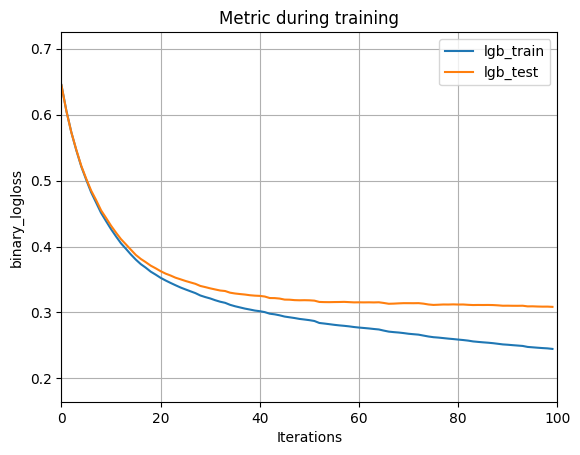

In [80]:
# 畫出訓練成果
ax = lgb.plot_metric(lbgm_history)
plt.show()

In [81]:
y_train_pred = model.predict(df_final_train)
y_test_pred = model.predict(df_final_test)

### Xgboost

In [82]:
# import xgboost as xgb


In [83]:
# clf = xgb.XGBClassifier()
# param_dist = {"n_estimators":sp_randint(50,100),
#               "max_depth": sp_randint(10,20)
#               }
# model = RandomizedSearchCV(clf, param_distributions=param_dist,
#                                    n_iter=5,cv=3,scoring='f1',random_state=25, return_train_score=True)


# model.fit(df_final_train,y_train)
# print('mean test scores',model.cv_results_['mean_test_score'])
# print('mean train scores',model.cv_results_['mean_train_score'])

In [84]:
# print(model.best_estimator_)

In [85]:
# xgb_model=xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
#        max_depth=14, min_child_weight=1, n_estimators=76,
#        n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
#        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, subsample=1)

In [86]:
# xgb_model.fit(df_final_train,y_train, eval_set=[(df_final_train, y_train), (df_final_test, y_test)]
#         , eval_metric='logloss')


In [87]:
# ax = lgb.plot_metric(lbgm_history)
# plt.plot(xbg_history['validation_0']['logloss'], label='xgb_train')
# plt.plot(xbg_history['validation_1']['logloss'], label='xgb_test')
# # show the legend 
# plt.legend()
#  # show the plot 
# plt.show()

In [88]:
# model = xgb_model

In [89]:
# y_train_pred = clf.predict(df_final_train)
# y_test_pred = clf.predict(df_final_test)

In [90]:
# # lgb_history 與 xgb_history畫在同一張圖

# ax = lgb.plot_metric(lbgm_history)
# plt.plot(lbgm_history['train']['auc'], label='train')
# plt.plot(lbgm_history['valid']['auc'], label='test')
# plt.plot(xbg_history['validation_0']['auc'], label='train')
# plt.plot(xbg_history['validation_1']['auc'], label='test')
# # show the legend
# plt.legend()
# # show the plot
# plt.show()




### Random Forest

In [91]:
# from sklearn.metrics import f1_score
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import f1_score
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint as sp_randint
# from scipy.stats import uniform

# param_dist = {"n_estimators":sp_randint(50,100),
#               "max_depth": sp_randint(10,20),
#               "min_samples_split": sp_randint(110,190),
#               "min_samples_leaf": sp_randint(25,65)}

# clf = RandomForestClassifier(random_state=25,n_jobs=-1)

# rf_model = RandomizedSearchCV(clf, param_distributions=param_dist,
#                                    n_iter=5,cv=10,scoring='f1',random_state=25, return_train_score=True)

# rf_model.fit(df_final_train,y_train)
# print('mean test scores',rf_model.cv_results_['mean_test_score'])
# print('mean train scores',rf_model.cv_results_['mean_train_score'])

In [92]:
# model = rf_model.best_estimator_

In [93]:
# print(model.best_estimator_)

In [94]:

# y_train_pred = model.predict(df_final_train)
# y_test_pred = model.predict(df_final_test)

In [95]:
# from sklearn.metrics import f1_score
# print('Train f1 score',f1_score(y_train,y_train_pred))
# print('Test f1 score',f1_score(y_test,y_test_pred))

## test data

In [96]:
submit_predict = model.predict(df_final_predict)

In [97]:
print(submit_predict.shape)

(6000,)


In [98]:
# 把預測結果寫入 submission.csv，格式為 'node_pair_id', 'ans'
submit = pd.DataFrame()
submit['node_pair_id'] = df_final_predict.index
submit['ans'] = submit_predict
submit.to_csv('./submission.csv', index=False)


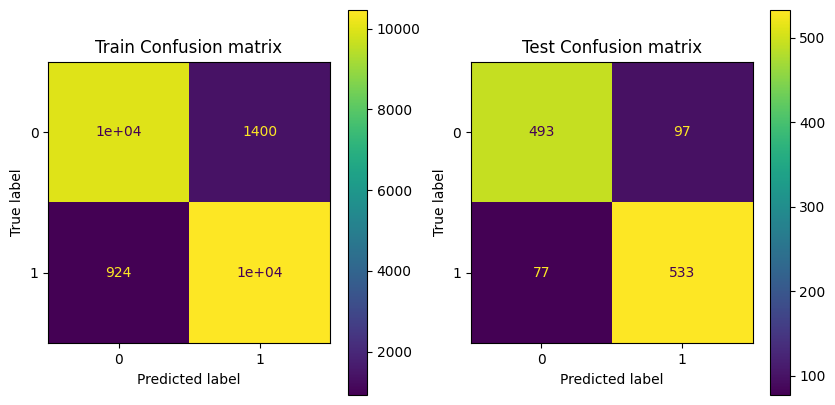

In [99]:
# from sklearn.metrics import plot_confusion_matrix
# print('Train confusion_matrix')
# plot_confusion_matrix(y_train,y_train_pred)
# print('Test confusion_matrix')
# plot_confusion_matrix(y_test,y_test_pred)
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
# 把兩張圖片畫在一起
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# 訓練集
disp = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=ax[0])
disp.ax_.set_title('Train Confusion matrix')
# 測試集
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=ax[1])
disp.ax_.set_title('Test Confusion matrix')
plt.show()


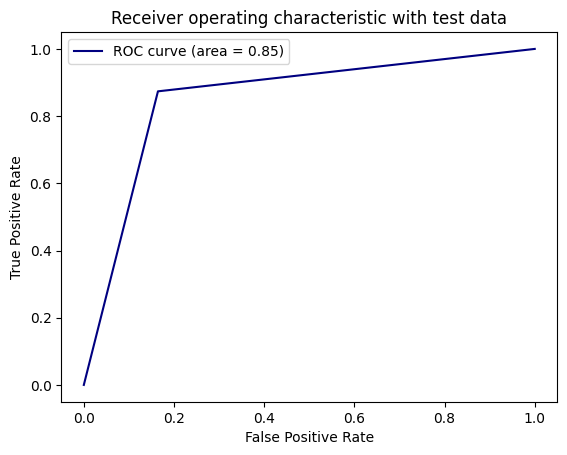

In [100]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

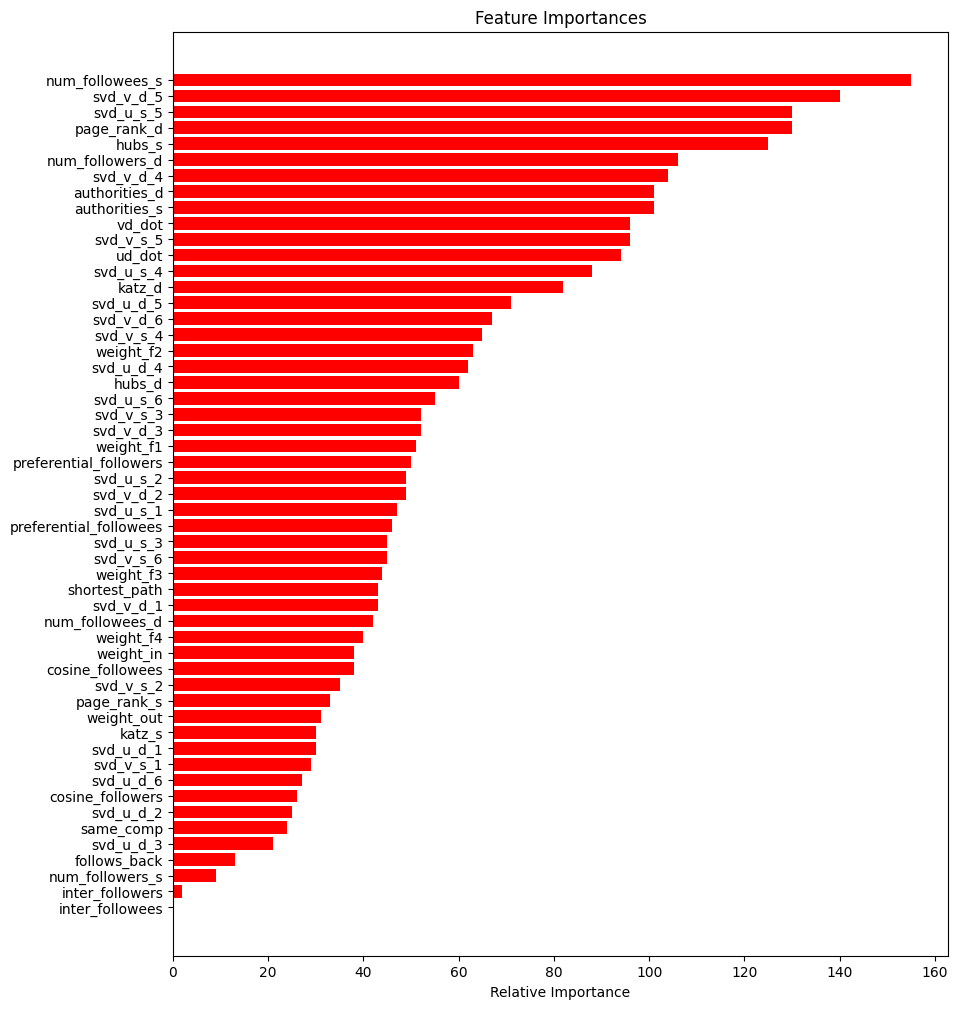

In [101]:
features = df_final_train.columns
importances = model.feature_importances_
indices = (np.argsort(importances))[:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()